In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
import itertools
plotmarkers=['^-', 'o-', 's-', '*-', 'd-', 'v-', 'h-', '>-', 'D-', 'H-', '<-', 'o-', 's-', '3-']
from scipy.optimize import curve_fit
import csv
%matplotlib inline

def pltDefaultPar():
    #reset default matplotlib parameters for this notebook
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8
    
    
figsizeRanb=(5, 3.5)#(6,4) is default size in inches
plt.rcParams.update({'font.size': 11}) #default is 10

from matplotlib.ticker import AutoMinorLocator  #Stuff for ticks
minorLocator = AutoMinorLocator(2)

rootTP="/home/johann/Remote/imac"
rootTP2="/home/johann/Remote2"
rootMAC="/Users/jh"
root=rootMAC


def stexp(x,a,n):
    return np.exp(-a*x**n)

# Function to plot D over phi vary lub noLub data with fixed aop
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phiOverlap(aob): # Old formula for phi for overlapping cylinders
    return (3*Vcyl(aob,b=1) - 8 * np.sqrt(2) * (aob/2.)**3)

def phiNoOverlap(aob): 
    return 3*Vcyl(aob,b=1) # This is almost the same formula as for the old model, but without the overlap term

def ptoPhi(data,aop,zeroa=False):
    prels=data[:,0]
    if zeroa:
        prels/=(1.+aop)
    phis=phiOverlap(prels*aop)
    data[:,0]=phis

In [2]:
# get D over p data for fixed kop aop and U in order to plot D over phi for different U_0
def getDop_kop_k_a_U_d(u,a=0,trigger='fixb',system='rand',d=0,k='1.000',kop=0,dt='0.0005',MSD="MSD",ranU=False):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    kstr=k
    adir="a"+str(a)
    if ranU and u!=0:
        initfolder+="ranU/"
    if system=='rand':
        initfolder+="rand/d"+str(d)+"/"
    if trigger=='fixb':
        initfolder+="fixb/"
    else: 
        return 'TODO'
    if trigger=='fixb' and d==0:
        initfolder=root+"/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/dt"+dt+"/t200/"
        adir="d0/b10"
    data=[]
    #print(folder)
    pArr=[]        
    for dtdir in os.listdir(initfolder): #search smallest dt first
        folder=initfolder+"/"+dtdir+"/t200/"+adir+"/"
        if os.path.isdir(folder):
            for pdir in os.listdir(folder): 
                if "DS" in pdir: continue
                p=float(pdir[1:])
                if p in pArr: continue
                prel=p/10.
                if kop!=0 and u!=0:
                    k=kop*p
                    kstr="{0:.3f}".format(k)
                file=os.path.join(folder,pdir,'k'+kstr+'/u'+str(u)+'/InstantValues/linear_fit_parameters'+MSD+'.txt')
                #print(file)
                if os.path.isfile(file):
                    pArr.append(p)
                    #print(file)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(prel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
                #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

In [3]:
# Function to plot D over p vary lub noLub data with fixed aop
def plotdata(dataArrs,xlabel,linelabels,linestyles='',noshow=False,addfig=False,loglog=False,legendloc=0,ncol=1,
             tofile=False,filename='test',fitexp=False,plotfit=False,ylim=[0,1.1],xlim=None,alph=0,nu=1.04,markercolor=None):
    if addfig==False: fig, ax = plt.subplots(figsize=figsizeRanb)
    if linestyles=='': lslist = len(dataArrs) * ['o-']
    elif linestyles=='markers': lslist=plotmarkers
    else: lslist = linestyles
    for i,data in enumerate(dataArrs):
        dd0s=data[:,1]/6.
        xvals=data[:,0]
        if loglog==True:
            plt.loglog(xvals,np.abs(np.log(dd0s)),lslist[i],label=linelabels[i])
            plt.xlabel("$\log("+xlabel+")$")
            plt.ylabel("$\log(|\log(D/D_0)|)$")
            if alph!=0:# plot a line in the log-plot
                xs=np.linspace(xvals[0],xvals[-1],100)
                ys=alph*xs**nu
                plt.loglog(xs,ys,'k-')
        else:
            plt.plot(xvals,dd0s,lslist[i],label=linelabels[i],markerfacecolor=markercolor)
            #plt.xlim([0,1])
            plt.xlabel(r'$'+xlabel+'$')
            plt.ylabel("$D/D_0$")
            if addfig==False:
                ax.xaxis.set_minor_locator(minorLocator)
                ax.yaxis.set_minor_locator(AutoMinorLocator(2))
            plt.locator_params(axis='x',nbins=7) #maximum number of xticks
        if fitexp:
            popt, pcov = curve_fit(stexp, xvals, dd0s,p0=[9,0.7],bounds=(0, [np.inf, np.inf]))
            print(linelabels[i],popt)
            if plotfit:
                xs = np.linspace(xvals[0],xvals[-1],100)
                ys = stexp(xs, *popt)
                plt.plot(xs,ys,'k-')
    plt.legend(ncol=ncol,loc=legendloc,fontsize = 'medium',frameon=False)
    plt.ylim(ylim)
    plt.xlim(xlim)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    if tofile==True:
        pp = PdfPages('figures/'+filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    if noshow==False:
        plt.show()

### k/p=0.5 and d=1 (ordered)

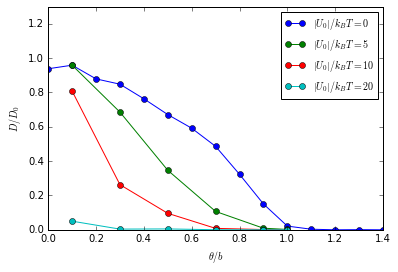

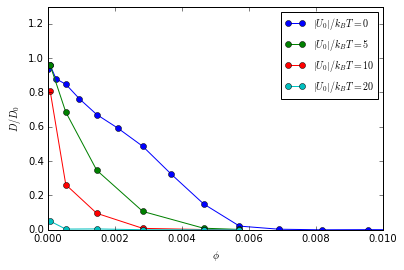

In [5]:
# TODO get p=1 U=20 data from sheldon
a=0;
kop=0.5
d=1
uArr=[0,5,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop,ranU=True) for u in uArr]
titleArr = ['$|U_0|/k_BT = '+str(u)+'$' for u in uArr]
plotdata(dataArr,r'\theta/b',titleArr,linestyles='',loglog=False,tofile=False,filename='',fitexp=False,plotfit=False)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aop=aoptest)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d1_ranU',
         xlim=[0,0.01],fitexp=False,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_ranU_log',fitexp=False,plotfit=False)


### k/p=0.5 and d=9 (random)

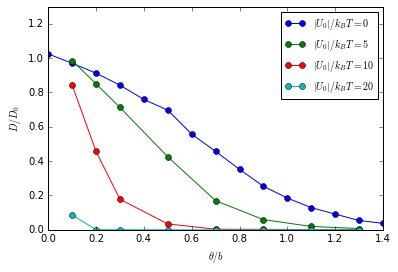

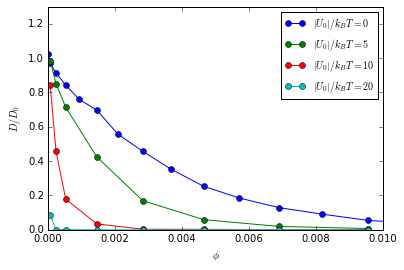

In [5]:
a=0;
kop=0.5
d=9
uArr=[0,5,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop,ranU=True) for u in uArr]
titleArr = ['$|U_0|/k_BT = '+str(u)+'$' for u in uArr]
plotdata(dataArr,r'\theta/b',titleArr,linestyles='',loglog=False,tofile=False,filename='',fitexp=False,plotfit=False)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aop=aoptest)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_ranU',
         xlim=[0,0.01],fitexp=False,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_ranU_log',fitexp=False,plotfit=False)


### kop = 1.5 data

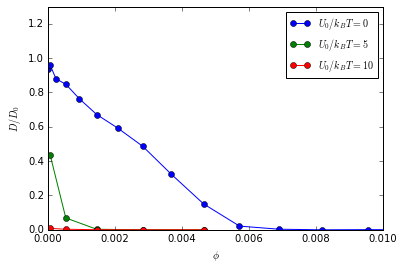

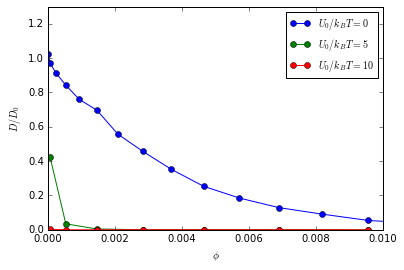

In [19]:
a=0
kop=1.5
uArr=[0,5,10]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop

d=1
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop,ranU=True) for u in uArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aop=aoptest)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d1_ranU',
         xlim=[0,0.01],fitexp=False,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d9_ranU_log',fitexp=False,plotfit=False)


d=9
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop,ranU=True) for u in uArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aop=aoptest)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d9_ranU',
         xlim=[0,0.01],fitexp=False,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d9_ranU_log',fitexp=False,plotfit=False)

### Conclusion
- For long ranges $k/p=1.5$ there seems to be a stronger effect of the interaction potential for the ranU model for both $d=0.1b$ and $d=0.9b$. This is quite interesting. Maybe there are deeper potential wells in this model, due to the different signs of the polymer charges.

#### For both k=0.5 theta and k=1.5 theta:
- In comparison to the homogeneously charged lattice, the ordered d=0.1b case neither shows the non-monotonic behavior of the attractive case (Figs. 7b and 8b), neither the stagnation of the repulsive U=10kT case (Fig. 8a ).
- In fact, the ordered d=0.1b case looks exactly like the random d=0.9b case. A random charge distribution seems to reduce lattice geometry effects, in particular for the k=1.5theta case.

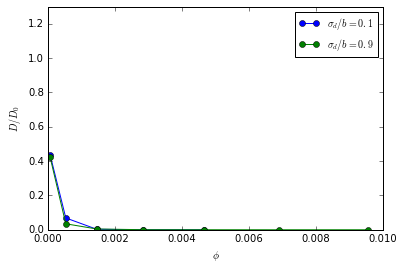

In [26]:
a=0
kop=1.5
u=5
dArr=[1,9]
titleArr = [r'$\sigma_d/b = '+str(d/10)+'$' for d in dArr]
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop

dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop,ranU=True) for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aop=aoptest)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d1_ranU',
         xlim=[0,0.01],fitexp=False,plotfit=False)


### TODO D over phi vary d = 1, 5, 9

### D over U

In [4]:
# get D over p data for fixed kop aop and U in order to plot D over phi for different U_0
def getDoU_k_a_p_d(k='1.000',p=0,a=0,trigger='fixb',system='rand',d=0,MSD='MSD',ranU=False):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    adir="a"+str(a)
    if ranU:
        initfolder+="ranU/"
    if system=='rand':
        initfolder+="rand/d"+str(d)+"/"
    if trigger=='fixb':
        initfolder+="fixb/"
    else: 
        return 'TODO'
    # if trigger=='fixb' and d==0 and ranU==False:
    #     initfolder=root+"/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/"
    #     adir="d0/b10"
    data=[]
    #print(folder)
    uArr=[]        
    for dtdir in os.listdir(initfolder): #search smallest dt first
        folder=initfolder+"/"+dtdir+"/t200/"+adir+'/p'+str(p)+'/k'+k
        if os.path.isdir(folder):
            for udir in os.listdir(folder): 
                if "DS" in udir: continue
                #print(folder+'/'+udir)
                u=float(udir[1:])
                if u in uArr: continue
                file=os.path.join(folder,udir,'InstantValues/linear_fit_parameters'+MSD+'.txt')
                #print(file)
                if os.path.isfile(file):
                    uArr.append(u)
                    #print(file)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
                #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

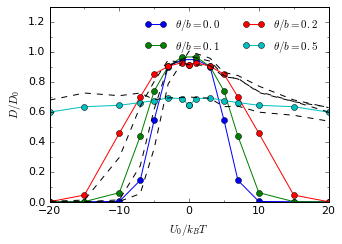

In [6]:
# Do U v p d=9
a=0; k='1.000'; d=9
Arr=[0,1,2,5]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d,ranU=True) for x in Arr]
dataArr=[np.concatenate((dat,dat*[-1,1])) for dat in dataArr]
dataArr=[arr[arr[:,0].argsort()] for arr in dataArr]
titleArr = [r'$\theta/b = '+str(x/10.)+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,noshow=True)

# Do U v p d=9
a=0; k='1.000'; d=9
Arr=[0,1,2,5]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d) for x in Arr]
titleArr = ['' for x in Arr]
lsArr=['k--' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles=lsArr,ncol=2,ylim=[0,1.3],xlim=[-20,20],addfig=True)



$\phi = 5.32757401337e-05$
$\phi = 0.000212492135111$
$\phi = 0.00131662286775$


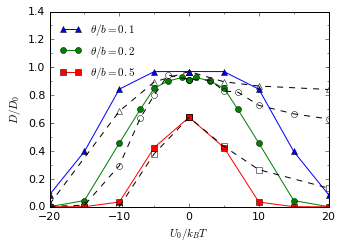

In [8]:
# Do U v p d=9
a=0; kop=0.5; d=9
aop=0.05
Arr=[1,2,5]
dataArr=[getDoU_k_a_p_d(k="{0:.3f}".format(kop*x),p=x,a=a,d=d,ranU=True) for x in Arr]
dataArr=[np.concatenate((dat,dat*[-1,1])) for dat in dataArr]
dataArr=[arr[arr[:,0].argsort()] for arr in dataArr]
titleArr = [r'$\theta/b = '+str(x/10.)+'$' for x in Arr]
phiArr = [r'$\phi = '+str(phiOverlap(x/10. * aop/(1+aop)))+'$' for x in Arr]
for phi in phiArr:
    print(phi)
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles='markers',noshow=True)

# Do U v p d=9
dataArr=[getDoU_k_a_p_d(k="{0:.3f}".format(kop*x),p=x,a=a,d=d) for x in Arr]
titleArr = ['' for x in Arr]
lsArr=['k^--', 'ko--', 'ks--', 'k*--', 'kd--']
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles=lsArr,ncol=1,ylim=[0,1.4],xlim=[-20,20],addfig=True,
         tofile=True,filename='D_over_U_vary_phi_a0_kop05_d9_ranU',markercolor="none")

$\phi = 5.32757401337e-05$
$\phi = 0.000212492135111$
$\phi = 0.00131662286775$


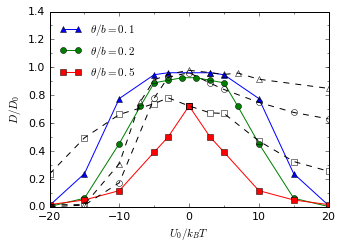

In [9]:
# Do U v p d=9
a=0; kop=0.5; d=0
aop=0.05
Arr=[1,2,5]
dataArr=[getDoU_k_a_p_d(k="{0:.3f}".format(kop*x),p=x,a=a,d=d,ranU=True) for x in Arr]
dataArr=[np.concatenate((dat,dat*[-1,1])) for dat in dataArr]
dataArr=[arr[arr[:,0].argsort()] for arr in dataArr]
titleArr = [r'$\theta/b = '+str(x/10.)+'$' for x in Arr]
phiArr = [r'$\phi = '+str(phiOverlap(x/10. * aop/(1+aop)))+'$' for x in Arr]
for phi in phiArr:
    print(phi)
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles='markers',noshow=True)

# Do U v p d=9
dataArr=[getDoU_k_a_p_d(k="{0:.3f}".format(kop*x),p=x,a=a,d=d) for x in Arr]
titleArr = ['' for x in Arr]
lsArr=['k^--', 'ko--', 'ks--', 'k*--', 'kd--']
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles=lsArr,ncol=1,ylim=[0,1.4],xlim=[-20,20],addfig=True,
         tofile=True,filename='D_over_U_vary_phi_a0_kop05_d0_ranU',markercolor="none")

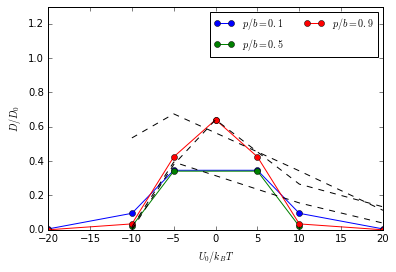

In [63]:
# Do U v p d=9
a=0; k='2.500'; p=5
Arr=[1,5,9]
dataArr=[getDoU_k_a_p_d(k=k,p=p,a=a,d=x,ranU=True) for x in Arr]
dataArr=[np.concatenate((dat,dat*[-1,1])) for dat in dataArr]
dataArr=[arr[arr[:,0].argsort()] for arr in dataArr]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,noshow=True)

# Do U v p d=9
dataArr=[getDoU_k_a_p_d(k=k,p=p,a=a,d=x) for x in Arr]
titleArr = ['' for x in Arr]
lsArr=['k--' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles=lsArr,ncol=2,ylim=[0,1.3],xlim=[-20,20],addfig=True)

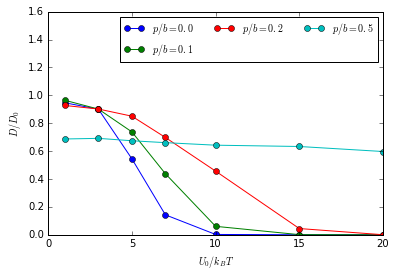

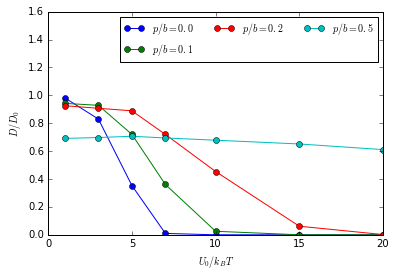

In [9]:
# Do U v p d=9
a=0; k='1.000'; d=9
Arr=[0,1,2,5]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d,ranU=True) for x in Arr]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[0,20])

# Do U v p d=3
a=0; k='1.000'; d=0
Arr=[0,1,2,5]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d,ranU=True) for x in Arr]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]+['$p/b=0.1$']
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[0,20])

### Conclusion
This looks pretty much the same. So the dependency on $U_0$ does not change very much with changing $d$.